# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter

In [3]:
from ubs8k.datasetManager import DatasetManager
from ubs8k.datasets import Dataset

from DCT.util.utils import reset_seed, get_datetime
from DCT.util.model_loader import get_model_from_name
from DCT.util.dataset_loader import load_dataset
from DCT.util.checkpoint import CheckPoint
from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

/home/lcances/sync/Documents_sync/Projet/PyTorch/audio/torchaudio/extension/extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



# Arguments

In [4]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="SpeechCommand", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="resnet34", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=256, type=int)
group_t.add_argument("--nb_epoch", default=200, type=int)
group_t.add_argument("--learning_rate", default=0.001, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=50, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [5]:
args

Namespace(batch_size=256, checkpoint_path='supervised', checkpoint_root='../model_save/', dataset='SpeechCommand', dataset_root='../datasets', from_config='', learning_rate=0.001, model='resnet34', nb_epoch=200, num_classes=50, resume=False, seed=1234, supervised_ratio=1.0, tensorboard_path='supervised', tensorboard_root='../tensorboard/', tensorboard_sufix='', train_folds=[1, 2, 3, 4], val_folds=[5])

# initialisation

In [6]:
reset_seed(args.seed)


# Prepare the dataset

In [7]:
args.dataset_root

'../datasets'

In [8]:
class PadUpTo(nn.Module):
    def __init__(self, target_length, mode: str = "constant", value: int = 0):
        super().__init__()
        self.target_length = target_length
        self.mode = mode
        self.value = value
        
    def forward(self, x):
        actual_length = x.size()[-1]
        return F.pad(input=x, pad=(0, (self.target_length - actual_length)), mode=self.mode, value=self.value)


In [9]:

from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

transforms = nn.Sequential(
    PadUpTo(target_length=16000, mode="constant", value=0),
    MelSpectrogram(sample_rate=16000, n_fft=2048, hop_length=512, n_mels=64), 
    AmplitudeToDB(),
)

In [10]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "supervised",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    transform=transforms,

    verbose = 2
)

../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified


# Prep model

In [11]:
import numpy as np
for x, y in train_loader:
    print(x.shape)
    print(len(np.unique(y.numpy())))
    break

torch.Size([256, 64, 32])
35


In [12]:
torch.cuda.empty_cache()

model_func = get_model_from_name(args.model)
# model_func = get_model_from_name("esc_wideresnet28_8")
model = model_func(input_shape=(64, 431), num_classes = args.num_classes)
model = model.cuda()


In [13]:
from torchsummaryX import summary
input_tensor = torch.zeros((1, 64, 431), dtype=torch.float)
input_tensor = input_tensor.cuda()

s = summary(model, input_tensor)


                                          Kernel Shape      Output Shape  \
Layer                                                                      
0_conv1                                  [3, 64, 7, 7]  [1, 64, 32, 216]   
1_bn1                                             [64]  [1, 64, 32, 216]   
2_relu                                               -  [1, 64, 32, 216]   
3_maxpool                                            -  [1, 64, 16, 108]   
4_layer1.0.Conv2d_conv1                 [64, 64, 3, 3]  [1, 64, 16, 108]   
5_layer1.0.BatchNorm2d_bn1                        [64]  [1, 64, 16, 108]   
6_layer1.0.ReLU_relu                                 -  [1, 64, 16, 108]   
7_layer1.0.Conv2d_conv2                 [64, 64, 3, 3]  [1, 64, 16, 108]   
8_layer1.0.BatchNorm2d_bn2                        [64]  [1, 64, 16, 108]   
9_layer1.0.ReLU_relu                                 -  [1, 64, 16, 108]   
10_layer1.1.Conv2d_conv1                [64, 64, 3, 3]  [1, 64, 16, 108]   
11_layer1.1.

## Prep training

In [14]:
nb_conv = 0

for layer in s.index.values:
    if "Conv" in layer:
        nb_conv += 1
print(nb_conv)

35


# training parameters

In [15]:
# tensorboard
title_element = (args.model, args.supervised_ratio, get_datetime(), model_func.__name__, args.supervised_ratio)
tensorboard_title = "%s/%sS/%s_%s_%.1fS" % title_element

title_element = (model_func.__name__, args.supervised_ratio)
checkpoint_title = "%s_%.1fS" % title_element

tensorboard = SummaryWriter(log_dir="%s/%s" % (tensorboard_path, tensorboard_title), comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

# losses
loss_ce = nn.CrossEntropyLoss(reduction="mean")

../tensorboard/SpeechCommand/supervised/resnet34/1.0S/2020-09-22_13:21:49_resnet34_1.0S


In [16]:
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)

In [17]:
tensorboard.add_hparams(tensorboard_params, {})

## cifar10 optimizer

In [18]:
if args.dataset == "cifar10":
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
    
    def lr_lambda(e):
        if e < 60:
            return 1

        elif 60 <= e < 120:
            return 0.2

        elif 120 <= e < 160:
            return 0.04

        else:
            return 0.008
    


## ubs8k optimizer

In [19]:
if args.dataset == "ubs8k":
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    lr_lambda = lambda epoch: (1.0 + numpy.cos((epoch-1)*numpy.pi/args.nb_epoch)) * 0.5

elif args.dataset in ("esc10", 'esc50'):
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    lr_lambda = lambda epoch: (1.0 + numpy.cos((epoch-1)*numpy.pi/args.nb_epoch)) * 0.5
    
elif args.dataset in ("SpeechCommand",):
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    lr_lambda = lambda epoch: (1.0 + numpy.cos((epoch-1)*numpy.pi/args.nb_epoch)) * 0.5


In [20]:
lr_scheduler = LambdaLR(optimizer, lr_lambda)

# Checkpoint
checkpoint = CheckPoint(model, optimizer, mode="max", name="%s/%s.torch" % (checkpoint_path, checkpoint_title))

# Metrics
fscore_fn = FScore()
acc_fn = CategoricalAccuracy()
avg = ContinueAverage()

reset_metrics = lambda : [m.reset() for m in [fscore_fn, acc_fn, avg]]

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

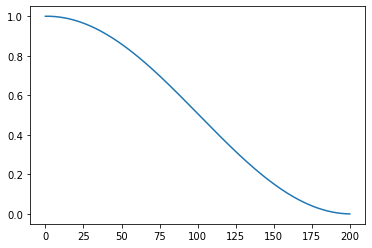

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, args.nb_epoch, args.nb_epoch)
y = [lr_lambda(x_) for x_ in x]

plt.plot(x, y)


In [22]:
def maximum():
    def func(key, value):
        if key not in func.max:
            func.max[key] = value
        else:
            if func.max[key] < value:
                func.max[key] = value
        return func.max[key]

    func.max = dict()
    return func
maximum_fn = maximum()

## Can resume previous training

In [23]:
if args.resume:
    checkpoint.load_last()

In [24]:
args.resume

False

## training function

In [25]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"


header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

header = header_form.format(
    ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
)


train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  


In [26]:
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    model.train()

    for i, (X, y) in enumerate(train_loader):        
        X = X.cuda()
        y = y.cuda()
        
        logits = model(X)        
        loss = loss_ce(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(train_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("train/Lce", avg_ce, epoch)
    tensorboard.add_scalar("train/f1", fscore, epoch)
    tensorboard.add_scalar("train/acc", acc, epoch)

In [27]:
def val(epoch):
    start_time = time.time()
    print("")
    reset_metrics()
    model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = model(X)
            loss = loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=args.num_classes)

            acc = acc_fn(pred_arg, y).mean
            fscore = fscore_fn(pred, y_one_hot).mean
            avg_ce = avg(loss.item()).mean

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    tensorboard.add_scalar("val/Lce", avg_ce, epoch)
    tensorboard.add_scalar("val/f1", fscore, epoch)
    tensorboard.add_scalar("val/acc", acc, epoch)
    
    tensorboard.add_scalar("hyperparameters/learning_rate", get_lr(optimizer), epoch)
    
    tensorboard.add_scalar("max/acc", maximum_fn("acc", acc), epoch )
    tensorboard.add_scalar("max/f1", maximum_fn("f1", fscore), epoch )

    checkpoint.step(acc)
    lr_scheduler.step()


In [ ]:
print(header)

start_epoch = checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    train(e)
    val(e)
    
    tensorboard.flush()
tensorboard.close()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          1.0536 -           0.6853    | 0.6694   - 118.4493
Validati 1      - 100    -          0.7903 -           0.7652    | 0.7779   - 24.3578
Training 2      - 100    -          0.4128 -           0.8729    | 0.8821   - 28.6948
Validati 2      - 100    -          0.5692 -           0.8359    | 0.8483   - 1.9061
Training 3      - 100    -          0.3127 -           0.9036    | 0.9111   - 28.2625
Validati 3      - 100    -          0.4139 -           0.8763    | 0.8870   - 1.9128
Training 4      - 100    -          0.2553 -           0.9196    | 0.9269   - 28.2308
Validati 4      - 100    -          0.4165 -           0.8832    | 0.8932   - 1.9030
Training 5      - 100    -          0.2181 -           0.9326    | 0.9386   - 28.2665
Validati 5      - 100    -          0.3762 -           0.8926    | 0.9039   - 1.8943
Training 6      - 100    -          0.1870 -           

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪